<a href="https://colab.research.google.com/github/rchabo/Projet_DDEFI_Amiral/blob/main/Code/Pipeline_ETL_Data_Map_EU_Storage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installations des bibliothèques

In [1]:
# Installer gdown
!pip install gdown geojson geopandas folium ipywidgets haversine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00


In [2]:
!pip install hdbscan

#Appel des Bibliothèques

In [3]:
#Importation des bibliothèques usuelles
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Pour le téléchargement des données depuis google drive
import gdown

#Pour le téléchargement des données depuis une API
import requests

# pour la lecture des fichiers geo et json
import geojson
import geopandas as gpd

import json
from pandas import json_normalize

#Pour créer la carte
import folium
import webbrowser
from ipywidgets import widgets, interactive
from IPython.display import display

#Pour le clustering géographique
from sklearn.cluster import DBSCAN, HDBSCAN
import hdbscan
from haversine import haversine, haversine_vector
from sklearn.metrics import silhouette_samples, silhouette_score

# pour exporter les données traitées en csv
from google.colab import files

In [4]:
# Modifier les options d'affichage pour ne pas tronquer les colonnes
pd.set_option('display.max_columns', None)

# Téléchargement et traitement des données

## *Liste des pays de l'UE élargie*

In [5]:
# Ce jeu présente la liste des pays et territoire qui alimente l’outil CurieXplore du MESRI
# Identifiant : curiexplore-pays
# Producteur : Ministère de l’Enseignement supérieur, de la Recherche et de l’Innovation
# site : https://data.enseignementsup-recherche.gouv.fr/explore/dataset/curiexplore-pays/information/?flg=fr-fr&disjunctive.iso3&sort=iso3&location=2,44.08908,1.84372&basemap=e69ab1

#téléchargement des données
url = "https://data.enseignementsup-recherche.gouv.fr/api/explore/v2.1/catalog/datasets/curiexplore-pays/records?select=iso3%2Ciso2%2Cname_en%2Cname_fr%2Cname_native%2Ceuropean_union%2Cue27%2Cg7&where=g7%20%3D%20%27True%27%20or%20ue27%20%3D%20%27True%27%20or%20european_union%20%3D%20%27True%27&limit=50"
response = requests.get(url)
data = response.json()
code_pays_UE = pd.DataFrame(data['results'])

#Remplacer 'True' et 'False' (en tant que chaînes) par leurs équivalents booléens dans les colonnes 'european_union', 'ue27', 'g7'
code_pays_UE[['european_union', 'ue27', 'g7']] = code_pays_UE[['european_union', 'ue27', 'g7']].replace({'True': True, 'False': False})

#Prendre l'Union Européenne élargie
code_pays_UE = code_pays_UE[code_pays_UE['european_union'] == True]

#Utiliser le nom courant du Royaume-Uni en anglais
code_pays_UE.loc[code_pays_UE['iso3'] == 'GBR', 'name_en'] = 'United Kingdom'

# DatFrame des pays en Europe
code_pays_UE

<ipython-input-5-97c432421363>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  code_pays_UE[['european_union', 'ue27', 'g7']] = code_pays_UE[['european_union', 'ue27', 'g7']].replace({'True': True, 'False': False})


iso3 iso2         name_en             name_fr      name_native  \
0   FRA   FR          France              France           France   
1   ITA   IT           Italy              Italie           Italia   
2   DEU   DE         Germany           Allemagne      Deutschland   
3   HRV   HR         Croatia             Croatie         Hrvatska   
4   ROU   RO         Romania            Roumanie          România   
5   LVA   LV          Latvia            Lettonie          Latvija   
6   AUT   AT         Austria            Autriche       Österreich   
7   LTU   LT       Lithuania            Lituanie          Lietuva   
8   ESP   ES           Spain             Espagne           España   
9   SVN   SI        Slovenia            Slovénie        Slovenija   
10  BEL   BE         Belgium            Belgique           België   
11  NLD   NL     Netherlands            Pays-Bas        Nederland   
12  POL   PL          Poland             Pologne           Polska   
13  CZE   CZ  Czech Republic  République tchèque  Česká republika   
14  SVK   SK        Slovakia           Slovaquie        Slovensko   
15  GRC   GR          Greece               Grèce           Ελλάδα   
16  FIN   FI         Finland            Finlande            Suomi   
17  SWE   SE          Sweden               Suède          Sverige   
18  DNK   DK         Denmark            Danemark          Danmark   
19  PRT   PT        Portugal            Portugal         Portugal   
20  BGR   BG        Bulgaria            Bulgarie         България   
21  CYP   CY          Cyprus              Chypre           Κύπρος   
22  HUN   HU         Hungary             Hongrie     Magyarország   
23  IRL   IE         Ireland             Irlande             Éire   
24  LUX   LU      Luxembourg          Luxembourg       Luxembourg   
25  EST   EE         Estonia             Estonie            Eesti   
26  MLT   MT           Malta               Malte            Malta   
27  GBR   GB  United Kingdom         Royaume-Uni   United Kingdom   
31  NOR   NO          Norway             Norvège            Norge   
32  ISL   IS         Iceland             Islande           Ísland   
33  LIE   LI   Liechtenstein       Liechtenstein    Liechtenstein   
34  TUR   TR          Turkey             Turquie          Türkiye   
35  SMR   SM      San Marino         Saint-Marin       San Marino   
36  AND   AD         Andorra             Andorre          Andorra   
37  MCO   MC          Monaco              Monaco           Monaco   
38  CHE   CH     Switzerland              Suisse          Schweiz   
39  VAT   VA    Vatican City             Vatican         Vaticano   

    european_union   ue27     g7  
0             True   True   True  
1             True   True   True  
2             True   True   True  
3             True   True  False  
4             True   True  False  
5             True   True  False  
6             True   True  False  
7             True   True  False  
8             True   True  False  
9             True   True  False  
10            True   True  False  
11            True   True  False  
12            True   True  False  
13            True   True  False  
14            True   True  False  
15            True   True  False  
16            True   True  False  
17            True   True  False  
18            True   True  False  
19            True   True  False  
20            True   True  False  
21            True   True  False  
22            True   True  False  
23            True   True  False  
24            True   True  False  
25            True   True  False  
26            True   True  False  
27            True  False   True  
31            True  False  False  
32            True  False  False  
33            True  False  False  
34            True  False  False  
35            True  False  False  
36            True  False  False  
37            True  False  False  
38            True  False  False  
39            True  False  False

## *Liste des coordonnées géographiques des villes*

In [6]:
# Liste des villes dans le monde avec une population supérieure à 500 habitants
# Identifiant : GeoNames - All Cities
# Producteur : Kaggle
# site : https://www.kaggle.com/datasets/joebeachcapital/geonames-all-cities

# Lien Google Drive pour le fichier GeoJSON (population > 500)
file_id = '1Z3C5oi2BfwT7AmmRRJDSHW5jJiH-My6v'  # ID extrait du lien Google Drive
output_file = 'geonames-all-cities-with-a-population-500.geojson'  # Nom local du fichier
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)

# Lire le fichier GeoJSON avec GeoPandas
cities_coord = gpd.read_file(output_file)

Downloading...
From (original): https://drive.google.com/uc?id=1Z3C5oi2BfwT7AmmRRJDSHW5jJiH-My6v
From (redirected): https://drive.google.com/uc?id=1Z3C5oi2BfwT7AmmRRJDSHW5jJiH-My6v&confirm=t&uuid=19626383-c1e1-4de2-8c7d-10b6362f94b2
To: /content/geonames-all-cities-with-a-population-500.geojson
100%|██████████| 123M/123M [00:01<00:00, 66.6MB/s]


In [7]:
# ne garder que les colonnes d'intérêt et les pays de l'UE élargie
cities_coord = cities_coord[['name','ascii_name','country','country_code','latitude','longitude']]
cities_coord = cities_coord[cities_coord['country_code'].isin(code_pays_UE["iso2"])]
cities_coord.sort_values(by=['country','name'], inplace=True)

cities_coord.head()

name        ascii_name  country country_code  latitude  \
76931   Andorra la Vella  Andorra la Vella  Andorra           AD  42.50779   
106216           Arinsal           Arinsal  Andorra           AD  42.57205   
172517           Canillo           Canillo  Andorra           AD   42.5676   
113457         El Tarter         El Tarter  Andorra           AD  42.57952   
106215            Encamp            Encamp  Andorra           AD  42.53474   

       longitude  
76931    1.52109  
106216   1.48453  
172517   1.59756  
113457   1.65362  
106215   1.58014

In [66]:
# Sauvegarde au format Parquet
cities_coord.to_parquet('cities_coord.parquet', engine='pyarrow', compression='snappy')
files.download("cities_coord.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## *Descriptif des technologies*

In [8]:
# Description des installations de stockage d'énergie dans l'UE-28, recensées par Direction générale de l'énergie de l'UE,
# opérationnelles ou en projet avec leurs caractéristiques
# Identifiant : Database of the European energy storage technologies and facilities
# Producteur : EU Directorate-General for Energy
# site : https://data.europa.eu/data/datasets/database-of-the-european-energy-storage-technologies-and-facilities?locale=en

url = "https://data.europa.eu/euodp/repository/ec/ener/Energy_Storage_T1_Database_2020.xlsx"
data_tech_nrj_storage = pd.read_excel(url, sheet_name ='Energy Storage Technologies')

# Remplir les valeurs manquantes dues à la mise en forme de excel
data_tech_nrj_storage["Technologies"].ffill(inplace=True)

data_tech_nrj_storage.head(25)

<ipython-input-8-0ccde5e4056d>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_tech_nrj_storage["Technologies"].ffill(inplace=True)


Technologies                                 Sub-technologies      Use  \
0        Mechanical                       Pumped Hydro Storage (PHS)      FTM   
1        Mechanical            Pumped Heat Electrical Storage (PHES)      FTM   
2        Mechanical  Adiabatic Compressed Air Energy Storage (ACAES)      FTM   
3        Mechanical             Compressed Air Energy Storage (CAES)      FTM   
4        Mechanical                 Liquid Air Energy Storage (LAES)      FTM   
5        Mechanical                                         Flywheel      FTM   
6   ElectroChemical                         Sodium Sulphur batteries      FTM   
7   ElectroChemical                              Lead Acid batteries  FTM/BTM   
8   ElectroChemical                 Sodium Nickel Chloride batteries      FTM   
9   ElectroChemical                            Lithium-ion batteries  FTM/BTM   
10  ElectroChemical                          Lithium-S batteries R&D  FTM/BTM   
11  ElectroChemical                  Lithium-Metal-Polymer batteries  FTM/BTM   
12  ElectroChemical                          Metal Air batteries R&D      FTM   
13  ElectroChemical                                  Ni-Cd batteries      NaN   
14  ElectroChemical                                  Ni-MH batteries      NaN   
15  ElectroChemical                             Na-ion batteries R&D  FTM/BTM   
16  ElectroChemical                       Redow flow batteries Zn Fe      FTM   
17  ElectroChemical                    Redox flow batteries Vanadium      FTM   
18  ElectroChemical                       Redox flow batteries Zn Br      FTM   
19       Electrical   Superconducting Magnetic Energy Storage (SMES)      FTM   
20       Electrical                                   Supercapacitor      FTM   
21         Chemical                                Power to Gas (H2)      FTM   
22         Chemical                      Power to Ammonia - Gasoline      FTM   
23         Chemical                                 Power to Methane      FTM   
24         Chemical                     Power to Methanol + Gasoline      FTM   

     Energy Capacity  Power installed capacity   \
0           1-100 GWh               100 MW-1 GW   
1       500 kWh-1 GWh             100 kW-200 MW   
2       10 MWh-10 GWh                 10-300 MW   
3       10 MWh-10 GWh                 10-300 MW   
4        10 MWh-8 GWh                 5-650 MW    
5            5-10 kWh                   1-20 MW   
6           < 100 MWh                   < 10 MW   
7        up to 10 MWh                   Some MW   
8      4 kWh- 10 MWh                 Several MW   
9            < 10 MWh                   < 50 MW   
10                NaN                       NaN   
11                NaN                       NaN   
12                NaN                       NaN   
13           some MWh                   some MW   
14           some MWh                   some MW   
15                NaN                       NaN   
16          < 100 MWh                   < 10 MW   
17          < 100 MWh                   < 10 MW   
18          < 100 MWh                   < 10 MW   
19           1-10 kWh                 100kW-5MW   
20            1-5 kWh                 100kW-5MW   
21      up to 100 GWh                 1kW -1 GW   
22  1 MWh-several GWh                 1 MW-1 GW   
23  1 MWh-several GWh                 1 MW-1 GW   
24  1 MWh-several GWh                 1 MW-1 GW   

   Storage duration at full power CAPEX (€/kW) Average CAPEX (€/kWh, 2016)  \
0                   several hours     500-1500                          19   
1                       3-6 hours          350                         NaN   
2                   several hours    1200-2000                         NaN   
3                   several hours     400-1200                          47   
4                      2-24 hours     500-3500                         NaN   
5                    5-30 minutes     500-2000                        2750   
6                         6

## *Liste des projets DG Energy*

In [9]:
# Liste de toutes les installations de stockage d'énergie dans l'UE-28, recensées par Direction générale de l'énergie de l'UE,
# opérationnelles ou en projet, qui sont connectées au réseau de production et de transport, avec leurs caractéristiques
# Identifiant : Database of the European energy storage technologies and facilities
# Producteur : EU Directorate-General for Energy
# site : https://data.europa.eu/data/datasets/database-of-the-european-energy-storage-technologies-and-facilities?locale=en

url = "https://data.europa.eu/euodp/repository/ec/ener/Energy_Storage_T1_Database_2020.xlsx"
data_DG_storage = pd.read_excel(url, sheet_name ='Facilities Data')
data_DG_storage.head()

Country      City Facility Name Facility Status Technology type  \
0  Austria  Mallnitz     Feldsee-1     Operational      Mechanical   
1  Austria  Mallnitz     Feldsee-2     Operational      Mechanical   
2  Austria       NaN       Fragant     Operational      Mechanical   
3  Austria  Häusling      Häusling     Operational      Mechanical   
4  Austria      Berg    Hintermuhr     Operational      Mechanical   

  Sub-technology Power installed capacity (MW) Energy Capacity (MWh)  \
0            PHS                            70                   NaN   
1            PHS                            70                   NaN   
2            PHS                           334                   NaN   
3            PHS                           360                   NaN   
4            PHS                           104                   NaN   

  Grid connection level Grid Operator  Date of commisionning     Operator  \
0                   NaN            NaN                  2009        Kelag   
1                   NaN            NaN                  2011        Kelag   
2                   NaN            NaN                  2007        Kelag   
3                   NaN            NaN                  1988      Verbund   
4                   NaN            NaN                  1992  Salzburg AG   

                Source Unnamed: 13  
0  Power Plant Tracker         NaN  
1  Power Plant Tracker         NaN  
2  Power Plant Tracker         NaN  
3  Power Plant Tracker         NaN  
4  Power Plant Tracker         NaN

In [10]:
#Ajouter une localisation aux emplacements de stockage d'énergie (latitude det longitude)
data_DG_storage = data_DG_storage.merge(cities_coord[['country', 'name', 'latitude', 'longitude']],
                                         left_on=['Country', 'City'],
                                         right_on=['country', 'name'],
                                         how='inner')

In [11]:
#Conversion des données dans les "bonnes" unités
data_DG_storage['Power installed capacity (MW)'] = pd.to_numeric(data_DG_storage['Power installed capacity (MW)'], errors='coerce')
data_DG_storage['Date of commisionning'] = pd.to_numeric(data_DG_storage['Date of commisionning'], errors='coerce').fillna(0).astype(int)
data_DG_storage['latitude'] = pd.to_numeric(data_DG_storage['latitude'], errors='coerce')
data_DG_storage['longitude'] = pd.to_numeric(data_DG_storage['longitude'], errors='coerce')

In [12]:
#Garder les colonnes d'intérêts
col_interest = ['Country','City','Facility Name','Facility Status','Technology type','Sub-technology','Power installed capacity (MW)','Date of commisionning','Source','latitude','longitude']
data_DG_storage = data_DG_storage[col_interest]
data_DG_storage.head()

Country       City     Facility Name Facility Status Technology type  \
0  Austria       Berg        Hintermuhr     Operational      Mechanical   
1  Austria       Berg        Hintermuhr     Operational      Mechanical   
2  Austria       Berg        Hintermuhr     Operational      Mechanical   
3  Austria     Kaprun  Kaprun-Oberstufe     Operational      Mechanical   
4  Austria  Kaunertal       Kaunertal-2       Announced      Mechanical   

  Sub-technology  Power installed capacity (MW)  Date of commisionning  \
0            PHS                          104.0                   1992   
1            PHS                          104.0                   1992   
2            PHS                          104.0                   1992   
3            PHS                          112.8                   1956   
4            PHS                          400.0                   2034   

                                              Source  latitude  longitude  
0                                Power Plant Tracker  48.29278   14.24778  
1                                Power Plant Tracker  46.74889   13.13111  
2                                Power Plant Tracker  48.10147   17.03842  
3                                Power Plant Tracker  47.27239   12.75985  
4  https://tyndp.entsoe.eu/tyndp2018/projects/sto...  47.03067   10.74594

## *Liste des projets DOE US*

In [13]:
# La base de données mondiale du DOE sur le stockage de l'énergie fournit des informations de qualité
# sur les projets de stockage de l'énergie raccordés au réseau et sur les politiques fédérales et nationales en la matière.
# À partir du 22 septembre 2023, cette page servira de centre officiel pour la base de données mondiale sur le stockage de l'énergie.
# Identifiant : DOE Global Energy Storage Database
# Producteur : US Department Of Energy
# site : https://gesdb.sandia.gov/projects.html

# ID du fichier Google Drive (L'ID du fichier est la partie entre /d/ et /edit.)
file_id = '1fzNi8nJHwOJvvLY93b5NBQT_dEvIs94V'
output_file = 'GESDB_Project_Data.json'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)
data_DOE_storage = pd.read_json(output_file)

data_DOE_storage.head()

Downloading...
From: https://drive.google.com/uc?id=1fzNi8nJHwOJvvLY93b5NBQT_dEvIs94V
To: /content/GESDB_Project_Data.json
100%|██████████| 12.1M/12.1M [00:00<00:00, 51.2MB/s]


ID  Subsystem ID Data Source  \
0   1           1.1       GESDB   
1   2           2.1       GESDB   
2   3           3.1       GESDB   
3   3           3.2       GESDB   
4   3           3.3       GESDB   

                                  Project/Plant Name       Status  \
0  Ponale Test (Riva del Garda Ledro) Hydroelectr...  Operational   
1               Urdiceto Hydroelectric Power Station  Operational   
2                   Rocky River Pumped Storage Plant  Operational   
3                   Rocky River Pumped Storage Plant  Operational   
4                   Rocky River Pumped Storage Plant  Operational   

   Rated Power (kW)  Discharge Duration at Rated Power (hrs)  \
0           80000.0                                      0.0   
1            7200.0                                      0.0   
2            3500.0                                      0.0   
3            3500.0                                      0.0   
4           24000.0                                      0.0   

   Storage Capacity (kWh)                                       Applications  \
0                     0.0  {'Bulk Energy Services (General Energy Applica...   
1                     0.0  {'Bulk Energy Services (General Energy Applica...   
2                     0.0  {'Bulk Energy Services (General Energy Applica...   
3                     0.0  {'Bulk Energy Services (General Energy Applica...   
4                     0.0  {'Bulk Energy Services (General Energy Applica...   

  Paired Grid Resources                                  Description/Notes  \
0                  None  Ponale Hydroelectric Power Plant is a pumped s...   
1                  None  Spain is facing many challenges trying to inte...   
2                  None  The Connecticut Light &amp; Power Company pion...   
3                  None  The Connecticut Light &amp; Power Company pion...   
4                  None  The Connecticut Light &amp; Power Company pion...   

                                                 URL        Country  \
0                                http://www.enel.com          Italy   
1  http://www.iberdrola.es/webibd/gc/prod/en/doc/...          Spain   
2  http://www.asce.org/project/rocky-river-pumped...  United States   
3  http://www.asce.org/project/rocky-river-pumped...  United States   
4  http://www.asce.org/project/rocky-river-pumped...  United States   

             City      County State/Province/Territory Street Address  \
0  Riva del Garda        None                 Trentino           None   
1          Bielsa        None                   Aragon           None   
2     New Milford  Litchfield              Connecticut  200 Kent Road   
3     New Milford  Litchfield              Connecticut  200 Kent Road   
4     New Milford  Litchfield              Connecticut  200 Kent Road   

  Postal Code   Latitude  Longitude Announced Date Commissioned Date  \
0        None  45.888517    10.8400           None        11-04-1905   
1        None  42.633421     0.2200           None        01-01-1929   
2       06776  41.582600   -73.4349           None        01-01-1929   
3       06776  41.582600   -73.4349           None        01-01-1929   
4       06776  41.582600   -73.4349           None        01-01-1929   

  Constructed Date Decommissioned Date Latest Update Date  \
0             None                None         03-27-2023   
1             None                None         03-27-2023   
2             None                None         03-27-2023   
3             None                None         03-27-2023   
4             None                None         03-27-2023   

  Project Data Validated? Grid Interconnection Level  Interconnection Type  \
0                      NO               Transmission                   NaN   
1                      NO               Transmission                   NaN   
2                      NO               Transmission                   NaN   
3                      NO               Transmission            

In [14]:
#Filtrer les pays pour récupérer ceux de l'UE élargie
data_DOE_storage = data_DOE_storage[data_DOE_storage['Country'].isin(code_pays_UE["name_en"])]
data_DOE_storage.reset_index(drop=True, inplace=True)

In [15]:
#Normaliser la colonne 'storage device' qui contient encore du json avcxe les types de technologies
json_normalized = json_normalize(data_DOE_storage["Storage Device"])
json_normalized.set_index(data_DOE_storage.index, inplace=True)

In [16]:
# Fusionner les colonnes normalisées avec le DataFrame d'origine
data_DOE_storage[['Technology Broad Category', 'Technology Mid-Type']] = json_normalized[['Technology Broad Category', 'Technology Mid-Type']]

In [17]:
#Garder les colonnes d'intérêts
col_interest = ['Country','City','Project/Plant Name','Status','Technology Broad Category','Technology Mid-Type','Rated Power (kW)','Commissioned Date','Data Source','Latitude','Longitude']
data_DOE_storage = data_DOE_storage[col_interest]

In [18]:
#Conversion des données dans la "bonne unité"
data_DOE_storage['Rated Power (kW)'] = pd.to_numeric(data_DOE_storage['Rated Power (kW)'], errors='coerce')

# Multiplier la colonne DOE_EU['Rated Power (kW)'] par 10^-3 pour avoir des MW
data_DOE_storage['Rated Power (MW)'] = data_DOE_storage['Rated Power (kW)'] * 10**(-3)
data_DOE_storage = data_DOE_storage.drop(['Rated Power (kW)'], axis=1)

#récupérer les années et replir 0 si la date est inconnue
data_DOE_storage['Commissioned Date'] = pd.to_numeric(data_DOE_storage['Commissioned Date'], errors='coerce').fillna(0).astype(int)


In [19]:
data_DOE_storage.head()

Country            City  \
0           Italy  Riva del Garda   
1           Spain          Bielsa   
2     Switzerland         Sihlsee   
3  Czech Republic      Štěchovice   
4           Italy      Campotosto   

                                  Project/Plant Name       Status  \
0  Ponale Test (Riva del Garda Ledro) Hydroelectr...  Operational   
1               Urdiceto Hydroelectric Power Station  Operational   
2       Etzelwerk Pumped Hydro Storage Power Station  Operational   
3                    Štěchovice Pumped Hydro Station  Operational   
4                      Provvidenza Hydro Power Plant  Operational   

           Technology Broad Category   Technology Mid-Type  Commissioned Date  \
0  Electro-mechanical energy storage  Pumped hydro storage                  0   
1  Electro-mechanical energy storage  Pumped hydro storage                  0   
2  Electro-mechanical energy storage  Pumped hydro storage                  0   
3  Electro-mechanical energy storage  Pumped hydro storage                  0   
4  Electro-mechanical energy storage  Pumped hydro storage                  0   

  Data Source   Latitude  Longitude  Rated Power (MW)  
0       GESDB  45.888517      10.84              80.0  
1       GESDB  42.633421       0.22               7.2  
2       GESDB  47.136963       8.78             135.0  
3       GESDB  49.846401      14.42              45.0  
4       GESDB  42.557509      13.37             156.0

## *Liste des projets DG Energy et DOE US fusion pour la carte*

In [20]:
# Préparer la fusion des deux tables en renommant les colonnes

#Country
# OK

#City
# OK

#Facility Name
data_DOE_storage.rename(columns={"Project/Plant Name": "Facility Name"}, inplace=True)

#Facility Status
data_DOE_storage.rename(columns={"Status": "Facility Status"}, inplace=True)

#Technology type
data_DOE_storage.rename(columns={"Technology Broad Category": "Technology type"}, inplace=True)

#Sub-technology
data_DOE_storage.rename(columns={"Technology Mid-Type": "Sub-technology"}, inplace=True)

#Power installed capacity (MW)
data_DOE_storage.rename(columns={"Rated Power (MW)": "Power installed capacity (MW)"}, inplace=True)

#Date of commisionning
data_DOE_storage.rename(columns={"Commissioned Date": "Date of commisionning"}, inplace=True)

#Source
data_DOE_storage.rename(columns={"Data Source": "Source"}, inplace=True)

#latitude
data_DOE_storage.rename(columns={"Latitude": "latitude"}, inplace=True)

#latitude
data_DOE_storage.rename(columns={"Longitude": "longitude"}, inplace=True)

#Remettre dans l'ordre les colonnes de data_DOE_storage en se basant sur les colonnes dde data_DG_storage
col_DG = list(data_DG_storage.columns)
data_DOE_storage = data_DOE_storage[col_DG]
data_DOE_storage.head()

Country            City  \
0           Italy  Riva del Garda   
1           Spain          Bielsa   
2     Switzerland         Sihlsee   
3  Czech Republic      Štěchovice   
4           Italy      Campotosto   

                                       Facility Name Facility Status  \
0  Ponale Test (Riva del Garda Ledro) Hydroelectr...     Operational   
1               Urdiceto Hydroelectric Power Station     Operational   
2       Etzelwerk Pumped Hydro Storage Power Station     Operational   
3                    Štěchovice Pumped Hydro Station     Operational   
4                      Provvidenza Hydro Power Plant     Operational   

                     Technology type        Sub-technology  \
0  Electro-mechanical energy storage  Pumped hydro storage   
1  Electro-mechanical energy storage  Pumped hydro storage   
2  Electro-mechanical energy storage  Pumped hydro storage   
3  Electro-mechanical energy storage  Pumped hydro storage   
4  Electro-mechanical energy storage  Pumped hydro storage   

   Power installed capacity (MW)  Date of commisionning Source   latitude  \
0                           80.0                      0  GESDB  45.888517   
1                            7.2                      0  GESDB  42.633421   
2                          135.0                      0  GESDB  47.136963   
3                           45.0                      0  GESDB  49.846401   
4                          156.0                      0  GESDB  42.557509   

   longitude  
0      10.84  
1       0.22  
2       8.78  
3      14.42  
4      13.37

**Fusion des deux jeux de données :**

In [21]:
# Fusionner les deux DataFrames en utilisant merge sur les colonnes 'Country', 'City', 'Facility Name'
data_map = pd.merge(data_DG_storage, data_DOE_storage, on=['Country', 'City', 'Facility Name','Technology type', 'Sub-technology','Facility Status'], how='outer')

#Supprimer les doublons et fusionner les colonnes
data_map.drop_duplicates(subset=['Country', 'City', 'Facility Name','Facility Status'], keep='first', inplace=True)

In [22]:
#Traitement post fusion des données pour combiner les colonnes en double
data_map['Power installed capacity (MW)'] = data_map[['Power installed capacity (MW)_x', 'Power installed capacity (MW)_y']].max(axis=1)
data_map = data_map.drop(columns=['Power installed capacity (MW)_x', 'Power installed capacity (MW)_y'])

data_map['latitude'] = data_map['latitude_x'].combine_first(data_map['latitude_y'])
data_map = data_map.drop(columns=['latitude_x', 'latitude_y'])

data_map['longitude'] = data_map['longitude_x'].combine_first(data_map['longitude_y'])
data_map = data_map.drop(columns=['longitude_x', 'longitude_y'])

data_map['Source'] = data_map['Source_x'].combine_first(data_map['Source_y'])
data_map = data_map.drop(columns=['Source_x', 'Source_y'])

data_map['Date of commisionning'] = data_map['Date of commisionning_x'].combine_first(data_map['Date of commisionning_y'])
data_map = data_map.drop(columns=['Date of commisionning_x', 'Date of commisionning_y'])

# Trier le DataFrame fusionné par les colonnes 'Country', 'City', et 'Facility Name'
data_map = data_map.sort_values(by=['Country', 'City', 'Facility Name'], ascending=True)
data_map = data_map.reset_index(drop=True)

In [23]:
data_map.head()

Country         City                         Facility Name Facility Status  \
0  Austria         Berg                            Hintermuhr     Operational   
1  Austria     Flattach    Feldsee Pumped Storage Power Plant     Operational   
2  Austria  Frankenburg     BlueSky Energy Microgrid ViZn Z20     Operational   
3  Austria     Gaschurn  Kops II Pumped Storage Power Station     Operational   
4  Austria     Hausling   Häusling Pumped Storage Power Plant     Operational   

                                 Technology type        Sub-technology  \
0              Electro-mechanical energy storage  Pumped hydro storage   
1              Electro-mechanical energy storage  Pumped hydro storage   
2  Electro-chemical battery and chemical storage          Flow battery   
3              Electro-mechanical energy storage  Pumped hydro storage   
4              Electro-mechanical energy storage  Pumped hydro storage   

   Power installed capacity (MW)   latitude  longitude   Source  \
0                        104.000  48.103788  17.033729  EU Data   
1                        140.000  46.997820  13.042030    GESDB   
2                          0.064  48.068031  13.492145    GESDB   
3                        525.000  46.985810  10.030000    GESDB   
4                        360.000  47.145840  11.970000    GESDB   

   Date of commisionning  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0

**Nettoyer data_map :**

Uniformisation des dénominations des status

In [24]:
data_map['Facility Status'].unique()

array(['Operational', 'Authorized', 'Announced', 'Under construction',
       'Under Construction', 'De-Commissioned', 'Contracted',
       'Offline/Under Repair', 'Annocunced/never built', 'Submitted', nan,
       'Bidding process', 'Stopped', 'Announced/Never Built'],
      dtype=object)

In [25]:
# Uniformisation des dénominations pour : 'Facility Status'
# definition du dictionnaire pour uniformiser les catégories
category_mapping = {
    'Operational': 'Operational',
    'Authorized': 'Authorized',
    'Announced': 'Announced',
    'Under Construction': 'Under Construction',
    'Under construction': 'Under Construction',
    'De-Commissioned': 'De-Commissioned',
    'Contracted': 'Contracted',
    'Offline/Under Repair': 'Offline/Under Repair',
    'Annocunced/never built': 'Announced/Never Built',
    'Announced/Never Built': 'Announced/Never Built',
    'Submitted': 'Submitted',
    'Bidding process': 'Bidding process',
    'Stopped': 'Stopped',
    'Announced/Never Built': 'Announced/Never Built',
}

# Remplacer les catégories grâce au dictionnaire
data_map['Facility Status'] = data_map['Facility Status'].map(category_mapping)

In [26]:
data_map['Facility Status'].fillna('Unknown', inplace=True)

<ipython-input-26-42f0795b320c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_map['Facility Status'].fillna('Unknown', inplace=True)


Uniformisation des dénominations des technologies

In [27]:
data_map['Technology type'].unique()

array(['Electro-mechanical energy storage',
       'Electro-chemical battery and chemical storage', 'Mechanical',
       'Electrochemical', nan, 'Thermal energy storage', 'Chemical',
       'Thermal', 'Electro-chemical'], dtype=object)

In [28]:
data_tech_nrj_storage["Technologies"].unique()

array(['Mechanical', 'ElectroChemical', 'Electrical', 'Chemical',
       'Thermal'], dtype=object)

In [29]:
# Uniformisation des dénominations pour : 'Technology type'
# definition du dictionnaire pour uniformiser les catégories
category_mapping = {
    'Mechanical': 'Mechanical',
    'Electro-mechanical energy storage': 'Mechanical',
    'Electro-chemical battery and chemical storage': 'Electro-chemical battery and chemical storage',
    'Thermal energy storage': 'Thermal',
    'Electrochemical': 'ElectroChemical',
    'Chemical': 'Chemical',
    'Thermal': 'Thermal',
    'Electro-chemical': 'ElectroChemical',
}

# Remplacer les catégories grâce au dictionnaire
data_map['Technology type'] = data_map['Technology type'].map(category_mapping)

In [30]:
data_map.loc[pd.isna(data_map['Technology type']),:]

Country      City         Facility Name     Facility Status  \
94   Finland  Lempäälä                LEMENE  Under Construction   
214  Germany   Leipzig  Speicherfarm Leipzig         Operational   

    Technology type Sub-technology  Power installed capacity (MW)  latitude  \
94              NaN            NaN                            2.4  61.31667   
214             NaN            NaN                           12.5  51.33962   

     longitude                                             Source  \
94    23.75000  https://www.businessfinland.fi/en/whats-new/ne...   
214   12.37129                                             Bnetza   

     Date of commisionning  
94                  2019.0  
214                    0.0



*   https://www.lempaalanenergia.fi/en/lemene-lempaala-energy-community/
Fuel cells
Fuel cells are electrochemical devices that use hydrogen as their fuel. Efficient and low-emission fuel cells can be used in decentralized electricity and heat production systems. In Lempäälä, next-generation fuel cells have been commissioned use for the first time in Finland. Two combined heat and power (CHP) fuel cell systems have been integrated into the Marjamäki smart grid, featuring next-generation solid oxide fuel cells. The combined power output of these two separate cells is 130 kW.
*   https://www.german-energy-solutions.de/GES/Redaktion/EN/News/2019/20190131-bmw-storage-leipzig.html With the increasing importance of electric drive systems for the mobility of the future, the spread of traction batteries is also growing. The automobile manufacturer BMW and the electricity trading company Energy2Market GmbH (e2m) have now developed a concept for the further use of batteries from electric vehicles: up to 700 traction batteries, most of which previously powered electric cars, now form a large accumulator with an output of 10 MW and a total capacity of 15 MWh on the BMW factory premises in Leipzig.





In [31]:
# Supression des projets dont la technologie n'est pas connue
data_map.dropna(subset=['Technology type'], inplace=True)

Uniformisation des sous-technologies

In [32]:
data_map['Sub-technology'].unique()

array(['Pumped hydro storage', 'Flow battery', 'PHS', 'Lead-acid battery',
       'Sodium-based battery', None, 'Flywheel', 'Hydrogen storage',
       'Lithium-ion battery', 'LiNiMnCoO2', 'Li-ion',
       'Heat thermal storage', 'Unknown', 'Lithium-Metal-Polymer', '',
       'P2G', 'Compressed air energy storage', nan,
       'Electro-chemical capacitor', 'Latent heat', 'Molten salts',
       'Sensible heat', 'Nickel-based battery', 'Li-ion (second life)',
       'Lead-acid (AGM)', 'Lead acid + Li-ion', 'STES'], dtype=object)

In [33]:
data_tech_nrj_storage["Sub-technologies"].unique()

array(['Pumped Hydro Storage (PHS)',
       'Pumped Heat Electrical Storage (PHES)',
       'Adiabatic Compressed Air Energy Storage (ACAES)',
       'Compressed Air Energy Storage (CAES)',
       'Liquid Air Energy Storage (LAES)', 'Flywheel',
       'Sodium Sulphur batteries', 'Lead Acid batteries',
       'Sodium Nickel Chloride batteries', 'Lithium-ion batteries',
       'Lithium-S batteries R&D', 'Lithium-Metal-Polymer batteries',
       'Metal Air batteries R&D', 'Ni-Cd batteries', 'Ni-MH batteries',
       'Na-ion batteries R&D', 'Redow flow batteries Zn Fe',
       'Redox flow batteries Vanadium', 'Redox flow batteries Zn Br',
       'Superconducting Magnetic Energy Storage (SMES)', 'Supercapacitor',
       'Power to Gas (H2)', 'Power to Ammonia - Gasoline',
       'Power to Methane', 'Power to Methanol + Gasoline', 'Molten salts',
       'Sensible Thermal Energy Storage (STES)',
       'Phase Change Material (PCM)', 'ThermoChemical Storage (TCS)'],
      dtype=object)

In [34]:
# Uniformisation des dénominations pour : 'Sub-technology'
# definition du dictionnaire pour uniformiser les catégories
category_mapping = {
    'PHS': 'Pumped Hydro Storage (PHS)',  # 'PHS' -> 'Pumped Hydro Storage (PHS)'
    'Flywheel': 'Flywheel',  # No change needed, already correctly mapped
    'Lithium-ion battery': 'Lithium-ion batteries',  # 'Lithium-ion battery' -> 'Lithium-ion batteries'
    'Sodium-based battery': 'Sodium Sulphur batteries',  # 'Sodium-based battery' -> 'Sodium Sulphur batteries'
    'Sensible heat': 'Sensible Thermal Energy Storage (STES)',  # 'Sensible heat' -> 'Sensible Thermal Energy Storage (STES)'
    'Pumped hydro storage': 'Pumped Hydro Storage (PHS)',  # 'Pumped hydro storage' -> 'Pumped Hydro Storage (PHS)'
    'Li-ion': 'Lithium-ion batteries',  # 'Li-ion' -> 'Lithium-ion batteries'
    'Nickel-based battery': 'Nickel-based batteries',  # 'Nickel-based battery' -> 'Nickel-based batteries'
    'Hydrogen storage': 'Power to Gas (H2)',  # 'Hydrogen storage' -> 'Power to Gas (H2)'
    'Flow battery': 'Redox flow batteries Vanadium',  # 'Flow battery' -> 'Redox flow batteries Vanadium'
    'LiNiMnCoO2': 'Lithium-ion batteries',  # 'LiNiMnCoO2' -> 'Lithium-ion batteries'
    'Unknown': 'Unknown',  # No change needed, already correctly mapped
    'Lithium-Metal-Polymer': 'Lithium-Metal-Polymer batteries',  # 'Lithium-Metal-Polymer' -> 'Lithium-Metal-Polymer batteries'
    'P2G': 'Power to Gas (H2)',  # 'P2G' -> 'Power to Gas (H2)'
    'Heat thermal storage': 'Sensible Thermal Energy Storage (STES)',  # 'Heat thermal storage' -> 'Sensible Thermal Energy Storage (STES)'
    'Lead-acid battery': 'Lead Acid batteries',  # 'Lead-acid battery' -> 'Lead Acid batteries'
    'nan': 'Unknown',  # Handle empty strings as 'Unknown'
    'Molten salts': 'Molten salts',  # 'Molten salts' -> 'Molten salts'
    'Latent heat': 'Phase Change Material (PCM)',  # 'Latent heat' -> 'Phase Change Material (PCM)'
    'Li-ion (second life)': 'Lithium-ion batteries',  # 'Li-ion (second life)' -> 'Lithium-ion batteries'
    'Lead-acid (AGM)': 'Lead Acid batteries',  # 'Lead-acid (AGM)' -> 'Lead Acid batteries'
    'Electro-chemical capacitor': 'Supercapacitor',  # 'Electro-chemical capacitor' -> 'Supercapacitor'
    'Lead acid + Li-ion': 'Lead Acid batteries + Lithium-ion batteries',  # 'Lead acid + Li-ion' -> 'Lead Acid batteries + Lithium-ion batteries'
    'Compressed air energy storage': 'Compressed Air Energy Storage (CAES)',  # 'Compressed air energy storage' -> 'Compressed Air Energy Storage (CAES)'
    'STES': 'Sensible Thermal Energy Storage (STES)'  # 'STES' -> 'Sensible Thermal Energy Storage (STES)'
}

# Remplacer les catégories grâce au dictionnaire
data_map['Sub-technology'] = data_map['Sub-technology'].map(category_mapping)

In [35]:
data_map.loc[pd.isna(data_map['Sub-technology']),:]

Country                                        City  \
64           Cyprus                                     Nicosie   
81          Denmark                                    Bornholm   
83          Denmark  HyBalance - Air Liquide Advanced Business    
98           France              Alba Nova 1 Solar Power Plant    
107          France                                       Corse   
158         Germany                                      Borkum   
163         Germany                                   Dörverden   
282         Ireland                                        Cork   
283         Ireland                                        Cork   
284         Ireland                                        Cork   
285         Ireland                                        Cork   
289         Ireland                                      Dublin   
292         Ireland                                     Dundalk   
293         Ireland                                      Galway   
294         Ireland                                      Galway   
295         Ireland                                     Kildare   
296         Ireland                                    Kilkenny   
297         Ireland                                    Kilkenny   
298         Ireland                                     Leitrim   
299         Ireland                                    Limerick   
304         Ireland                                   Tipperary   
306         Ireland                                   Waterford   
394     Netherlands                                   Amsterdam   
415     Netherlands                                   Rotterdam   
422     Netherlands                                    Zeewolde   
548           Spain                               San Sebastián   
578          Sweden                                     Arlanda   
621  United Kingdom                                   Berkshire   
624  United Kingdom                                    Butleigh   

                                         Facility Name Facility Status  \
64                                             Nicosie       Announced   
81                                                BOSS       Announced   
83                                               Hobro     Operational   
98                                         Ghisonaccia     Operational   
107                                              Alata     Operational   
158   Borkum Island - Smart Grid Project - Netfficient     Operational   
163         Dörverden 3 MW Battery Storage - Statkraft     Operational   
282                           Kealkill Battery Storage       Announced   
283                       Killaveenoge Battery Storage       Submitted   
284                     Mishells Cross Battery Storage       Announced   
285            Polefield Battery Energy Storage System       Announced   
289                  Sillogue Battery Storage Facility       Submitted   
292  Dundalk Institute of Technology (DkIT) Wind Tu...     Operational   
293                                        Athenry ADC       Announced   
294                                 Barnaderg B.E.S.S.       Announced   
295                  Moatstown Battery\nEnergy Storage       Submitted   
296                           Glenmore Battery Storage       Announced   
297                Sionhermitage (prev Nore Power G&S)       Submitted   
298            Jamestown Battery Energy Storage System       Announced   
299                           Bawnmore Battery Storage       Announced   
304                                  Lisbrien B.E.S.S.       Announced   
306                                   Ballymac Storage       Announced   
394                             Amsterdam Energy Arena      Contracted   
415                                          Rotterdam     Operational   
422                                        FCR Storage     Operational   
548                        Micro-Grid I-Sare (Battery)     Operational   
578

Ajout des CAPEX

In [36]:
#Rajouter les CAPEX pour les technologies référencées
data_map = data_map.merge(
    data_tech_nrj_storage[
        ['Technologies', 'Sub-technologies', 'Average CAPEX (€/kWh, 2016)',
         'Max CAPEX (€/kWh, 2016)', 'CAPEX estimated 2030 (€/kWh)']
    ],
    left_on=['Technology type', 'Sub-technology'], right_on=['Technologies', 'Sub-technologies'],
    how='left'
)
data_map.drop(columns=['Technologies', 'Sub-technologies'], inplace=True)

In [37]:
# conversion dans les "bonnes" unités
data_map['Average CAPEX (€/kWh, 2016)'] = pd.to_numeric(data_map['Average CAPEX (€/kWh, 2016)'], errors='coerce')
data_map['Max CAPEX (€/kWh, 2016)'] = pd.to_numeric(data_map['Max CAPEX (€/kWh, 2016)'], errors='coerce')
data_map['CAPEX estimated 2030 (€/kWh)'] = pd.to_numeric(data_map['CAPEX estimated 2030 (€/kWh)'], errors='coerce')

data_map['Average CAPEX (€/kWh, 2016)'] = data_map['Average CAPEX (€/kWh, 2016)'].fillna(0)
data_map['Max CAPEX (€/kWh, 2016)'] = data_map['Max CAPEX (€/kWh, 2016)'].fillna(0)
data_map['CAPEX estimated 2030 (€/kWh)'] = data_map['CAPEX estimated 2030 (€/kWh)'].fillna(0)

Supression des projets dont la ville n'est pas connue ni les coordonnées géographiques

In [38]:
data_map.loc[pd.isna(data_map['City']),:]

Country  City                                      Facility Name  \
35          Austria  None           Kuhtai PSH (Kühtai Pumped Hydro Station)   
49          Belgium  None                                              Iland   
54         Bulgaria  None                                          Yadenitsa   
62          Croatia  None                                              Blato   
63          Croatia  None                                              Busco   
272         Germany  None  Germany Residential Energy Storage Systems - 3...   
305         Ireland  None               Mainstream Renewable Power - 2000 kW   
464        Portugal  None           Baixo Sabor Jusante Pumped Hydro Station   
465        Portugal  None    Baixo Sabor Montante Pumped Hydro Station - EDP   
466        Portugal  None             Frades II Pumped Hydro Station - Voith   
655  United Kingdom  None                             UK National Grid - RES   

    Facility Status                                Technology type  \
35      Operational                                     Mechanical   
49        Announced                                     Mechanical   
54        Announced                                     Mechanical   
62      Operational                                     Mechanical   
63      Operational                                     Mechanical   
272     Operational  Electro-chemical battery and chemical storage   
305     Operational                                     Mechanical   
464     Operational                                     Mechanical   
465     Operational                                     Mechanical   
466     Operational                                     Mechanical   
655      Contracted  Electro-chemical battery and chemical storage   

                 Sub-technology  Power installed capacity (MW)   latitude  \
35   Pumped Hydro Storage (PHS)                          289.0  47.253741   
49   Pumped Hydro Storage (PHS)                          550.0        NaN   
54   Pumped Hydro Storage (PHS)                          864.0        NaN   
62   Pumped Hydro Storage (PHS)                            4.2        NaN   
63   Pumped Hydro Storage (PHS)                            7.5        NaN   
272       Lithium-ion batteries                           68.0  51.000000   
305                    Flywheel                            2.0  53.412910   
464  Pumped Hydro Storage (PHS)                           37.0  39.399872   
465  Pumped Hydro Storage (PHS)                          145.0  39.399872   
466  Pumped Hydro Storage (PHS)                          778.0  39.399872   
655       Lithium-ion batteries                           20.0  55.378051   

     longitude   Source  Date of commisionning  Average CAPEX (€/kWh, 2016)  \
35    11.60000    GESDB                    0.0                         19.0   
49         NaN  EU Data                    0.0                         19.0   
54         NaN  EU Data                    0.0                         19.0   
62         NaN  EU Data                    0.0                         19.0   
63         NaN  EU Data                    0.0                         19.0   
272    7.00000    GESDB                    0.0                          0.0   
305   -8.24389    GESDB                    0.0                       2750.0   
464   -8.22000    GESDB                    0.0                         19.0   
465   -8.22000    GESDB                    0.0                         19.0   
466   -8.22000    GESDB                    0.0                         19.0   
655   -3.44000    GESDB                    0.0                          0.0   

     Max CAPEX (€/kWh, 2016)  CAPEX estimated 2030 (€/kWh)  
35                      90.1                          19.0  
49                      90.1                          19.0  
54                      90.1                          19.0  
62                      90.1                          19.0  
63                      90.1   

In [39]:
data_map.dropna(subset=['City'], inplace=True)

In [40]:
data_map.dropna(subset=['latitude'], inplace=True)

In [41]:
data_map.dropna(subset=['longitude'], inplace=True)

Supprilmer les projets dont la capacité n'est pas connue

In [42]:
data_map.dropna(subset=['Power installed capacity (MW)'], inplace=True)

Résumé :

In [43]:
data_map.info()

<class 'pandas.core.frame.DataFrame'>
Index: 639 entries, 0 to 654
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        639 non-null    object 
 1   City                           639 non-null    object 
 2   Facility Name                  639 non-null    object 
 3   Facility Status                639 non-null    object 
 4   Technology type                639 non-null    object 
 5   Sub-technology                 612 non-null    object 
 6   Power installed capacity (MW)  639 non-null    float64
 7   latitude                       639 non-null    float64
 8   longitude                      639 non-null    float64
 9   Source                         622 non-null    object 
 10  Date of commisionning          639 non-null    float64
 11  Average CAPEX (€/kWh, 2016)    639 non-null    float64
 12  Max CAPEX (€/kWh, 2016)        639 non-null    float64


In [44]:
display(data_map.head())

Country         City                         Facility Name Facility Status  \
0  Austria         Berg                            Hintermuhr     Operational   
1  Austria     Flattach    Feldsee Pumped Storage Power Plant     Operational   
2  Austria  Frankenburg     BlueSky Energy Microgrid ViZn Z20     Operational   
3  Austria     Gaschurn  Kops II Pumped Storage Power Station     Operational   
4  Austria     Hausling   Häusling Pumped Storage Power Plant     Operational   

                                 Technology type  \
0                                     Mechanical   
1                                     Mechanical   
2  Electro-chemical battery and chemical storage   
3                                     Mechanical   
4                                     Mechanical   

                  Sub-technology  Power installed capacity (MW)   latitude  \
0     Pumped Hydro Storage (PHS)                        104.000  48.103788   
1     Pumped Hydro Storage (PHS)                        140.000  46.997820   
2  Redox flow batteries Vanadium                          0.064  48.068031   
3     Pumped Hydro Storage (PHS)                        525.000  46.985810   
4     Pumped Hydro Storage (PHS)                        360.000  47.145840   

   longitude   Source  Date of commisionning  Average CAPEX (€/kWh, 2016)  \
0  17.033729  EU Data                    0.0                         19.0   
1  13.042030    GESDB                    0.0                         19.0   
2  13.492145    GESDB                    0.0                          0.0   
3  10.030000    GESDB                    0.0                         19.0   
4  11.970000    GESDB                    0.0                         19.0   

   Max CAPEX (€/kWh, 2016)  CAPEX estimated 2030 (€/kWh)  
0                     90.1                          19.0  
1                     90.1                          19.0  
2                      0.0                           0.0  
3                     90.1                          19.0  
4                     90.1                          19.0

## Analyse des chiffres clés

Nombre d'installations par statut des installations :
--------------------------------------------------


Facility Name  Percentage
Facility Status                                 
Operational                      540   84.507042
Announced                         51    7.981221
Contracted                        16    2.503912
De-Commissioned                   11    1.721440
Under Construction                 9    1.408451
Submitted                          5    0.782473
Announced/Never Built              2    0.312989
Authorized                         1    0.156495
Bidding process                    1    0.156495
Offline/Under Repair               1    0.156495
Stopped                            1    0.156495
Unknown                            1    0.156495

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

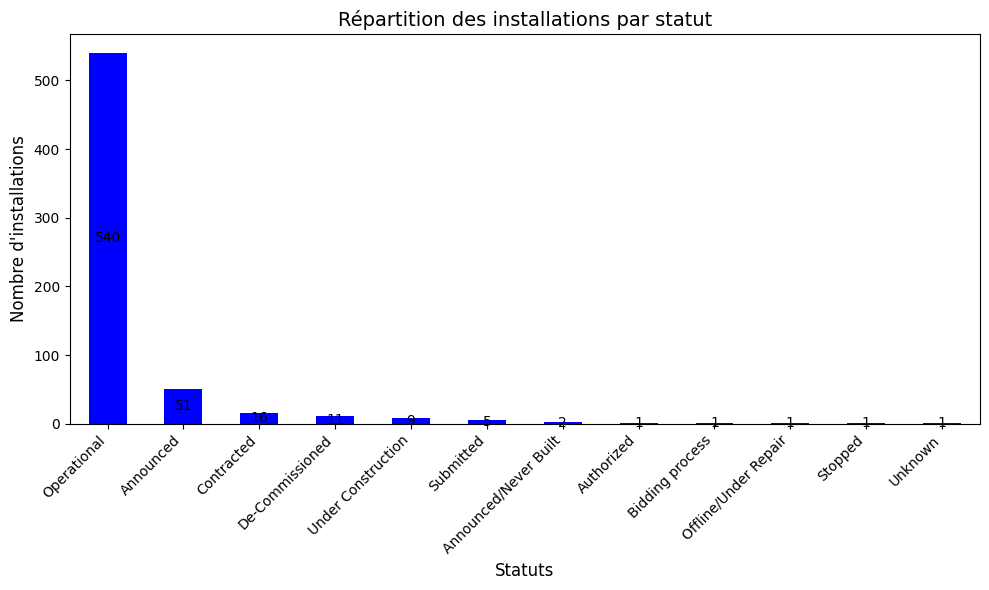

Types de technologies :
--------------------------------------------------


Facility Name  Percentage
Sub-technology                                                        
Pumped Hydro Storage (PHS)                             314   51.307190
Lithium-ion batteries                                  134   21.895425
Redox flow batteries Vanadium                           47    7.679739
Sensible Thermal Energy Storage (STES)                  29    4.738562
Sodium Sulphur batteries                                19    3.104575
Lead Acid batteries                                     17    2.777778
Flywheel                                                15    2.450980
Power to Gas (H2)                                       12    1.960784
Supercapacitor                                           7    1.143791
Compressed Air Energy Storage (CAES)                     5    0.816993
Unknown                                                  5    0.816993
Phase Change Material (PCM)                              3    0.490196
Molten salts                                             2    0.326797
Lead Acid batteries + Lithium-ion batteries              1    0.163399
Lithium-Metal-Polymer batteries                          1    0.163399
Nickel-based batteries                                   1    0.163399

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

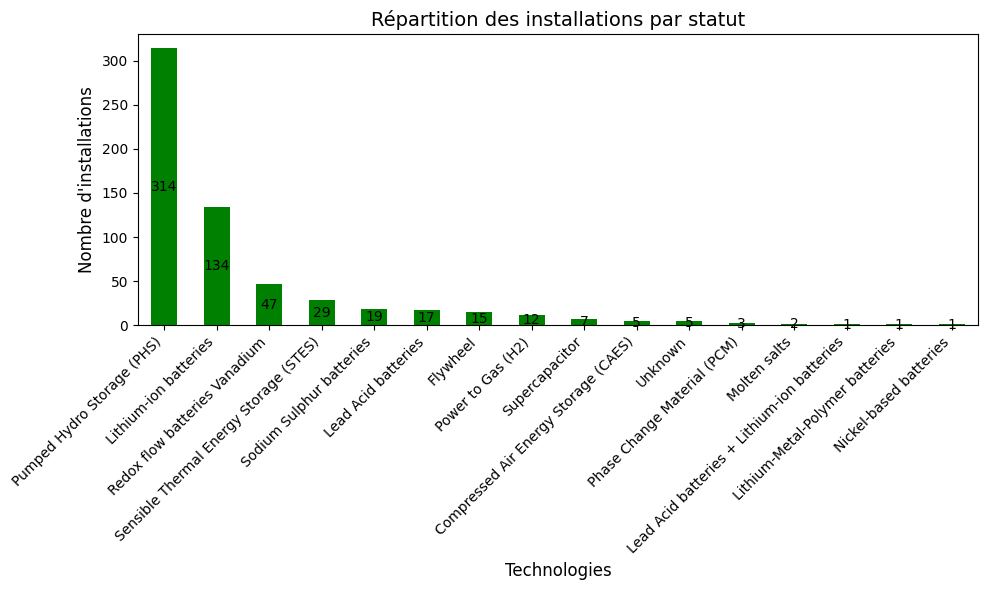

Types de technologies sur les projets non-opérationnels :
--------------------------------------------------


0  Percentage
Sub-technology                                             
Lithium-ion batteries                        24   30.379747
Pumped Hydro Storage (PHS)                   18   22.784810
Redox flow batteries Vanadium                14   17.721519
Unknown                                       4    5.063291
Lead Acid batteries                           3    3.797468
Power to Gas (H2)                             3    3.797468
Sodium Sulphur batteries                      3    3.797468
Compressed Air Energy Storage (CAES)          2    2.531646
Flywheel                                      2    2.531646
Sensible Thermal Energy Storage (STES)        2    2.531646
Lead Acid batteries + Lithium-ion batteries   1    1.265823
Lithium-Metal-Polymer batteries               1    1.265823
Phase Change Material (PCM)                   1    1.265823
Supercapacitor                                1    1.265823

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

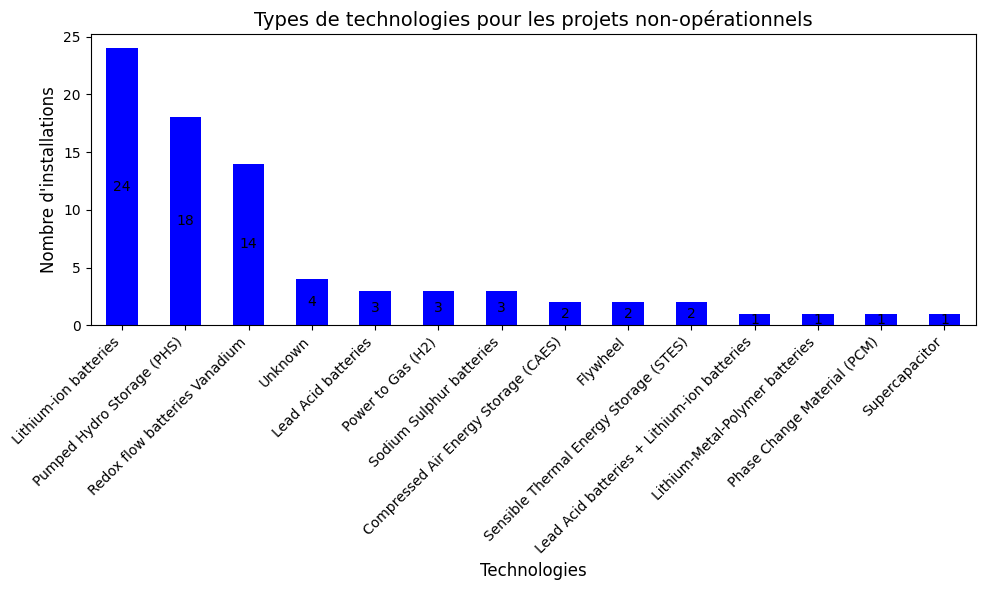

In [45]:
print("Nombre d'installations par statut des installations :")
print("-" * 50)
# Calculer le nombre d'installations par sous-technologie
df = data_map.groupby('Facility Status')['Facility Name'].count().sort_values(ascending=False)
total_facilities = df.sum()
df_percentage = df.to_frame()
df_percentage['Percentage'] = (df_percentage['Facility Name'] / total_facilities) * 100
display(df_percentage)

# Créer un graphique à barres empilées
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='winter')

# Ajouter un titre et labels
plt.title("Répartition des installations par statut", fontsize=14)
plt.xlabel("Statuts", fontsize=12)
plt.ylabel("Nombre d'installations", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher les valeurs sur les barres avec un décalage pour chaque niveau empilé
for p in ax.patches:
    height = p.get_height()
    y_position = p.get_y() + height / 2  # Positionner les valeurs au milieu de la barre
    ax.annotate(f'{height:.0f}',
                (p.get_x() + p.get_width() / 2., y_position),  # Position (x, y)
                ha='center', va='center', fontsize=10, color='black')
plt.savefig('repartition_statut_installations.png')
files.download('repartition_statut_installations.png')

plt.show()
##############################################################################################
print("Types de technologies :")
print("-" * 50)
df = data_map.groupby('Sub-technology')['Facility Name'].count().sort_values(ascending=False)
total_facilities = df.sum()
df_percentage = df.to_frame()
df_percentage['Percentage'] = (df_percentage['Facility Name'] / total_facilities) * 100
display(df_percentage)

# Créer un graphique à barres empilées
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='ocean')

# Ajouter un titre et labels
plt.title("Répartition des installations par statut", fontsize=14)
plt.xlabel("Technologies", fontsize=12)
plt.ylabel("Nombre d'installations", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher les valeurs sur les barres avec un décalage pour chaque niveau empilé
for p in ax.patches:
    height = p.get_height()
    y_position = p.get_y() + height / 2  # Positionner les valeurs au milieu de la barre
    ax.annotate(f'{height:.0f}',
                (p.get_x() + p.get_width() / 2., y_position),  # Position (x, y)
                ha='center', va='center', fontsize=10, color='black')
plt.savefig('repartition_technologies.png')
files.download('repartition_technologies.png')
plt.show()
##############################################################################################
print("Types de technologies sur les projets non-opérationnels :")
print("-" * 50)
df = data_map[~data_map['Facility Status'].isin(['Operational', 'Stopped', 'Announced/Never Built'])] \
    .groupby('Sub-technology') \
    .size() \
    .sort_values(ascending=False)

total_facilities = df.sum()
df_percentage = df.to_frame()
df_percentage['Percentage'] = (df_percentage / total_facilities) * 100
display(df_percentage)

# Créer un graphique à barres empilées
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='winter')

# Ajouter un titre et labels
plt.title("Types de technologies pour les projets non-opérationnels", fontsize=14)
plt.xlabel("Technologies", fontsize=12)
plt.ylabel("Nombre d'installations", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher les valeurs sur les barres avec un décalage pour chaque niveau empilé
for p in ax.patches:
    height = p.get_height()
    y_position = p.get_y() + height / 2  # Positionner les valeurs au milieu de la barre
    ax.annotate(f'{height:.0f}',
                (p.get_x() + p.get_width() / 2., y_position),  # Position (x, y)
                ha='center', va='center', fontsize=10, color='black')
plt.savefig('repartition_technologies_op.png')
files.download('repartition_technologies_op.png')
plt.show()

# Sauvegarde des données

In [46]:
# Exporter le DataFrame data_map en CSV
data_map.to_csv("data_map_EU_storage.csv", index=True)
files.download("data_map_EU_storage.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
# Sauvegarde au format Parquet
data_map.to_parquet('data_map_EU_storage.parquet', engine='pyarrow', compression='snappy')
files.download("data_map_EU_storage.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Analyse des résultats

## Carte des emplacements de stockage d'énergie

In [47]:
# Créer la carte centrée sur l'Europe
m = folium.Map(location=[50, 10], zoom_start=5)

Légende dynamique

In [48]:
data_map['Facility Status'].unique()

array(['Operational', 'Authorized', 'Announced', 'Under Construction',
       'De-Commissioned', 'Contracted', 'Offline/Under Repair',
       'Announced/Never Built', 'Submitted', 'Unknown', 'Bidding process',
       'Stopped'], dtype=object)

In [49]:
# Fonction pour définir la couleur en fonction de l'état 'Facility Status'

def get_marker_color(facility_status):
    # Définir une couleur spécifique pour chaque statut
    status_colors = {
        'Operational': 'green',
        'Authorized': 'blue',
        'Announced': 'purple',
        'Under Construction': 'orange',
        'De-Commissioned': 'gray',
        'Contracted': 'lightblue',
        'Offline/Under Repair': 'red',
        'Announced/Never Built': 'lightgray',
        'Submitted': 'yellow',
        'Bidding process': 'pink',
        'Stopped' : 'black'
    }
    return status_colors.get(facility_status, 'black')  # Noir par défaut si statut inconnu

Ajout des marqueurs

In [50]:
# Boucle pour ajouter des marqueurs avec des couleurs dynamiques
for _, row in data_map.iterrows():

    # Déterminer la couleur du marqueur en fonction du statut
    color = get_marker_color(row['Facility Status'])

    # Créer et ajouter le marqueur à la carte avec la couleur dynamique
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(
            f"""
            <b>Facility Name:</b> {row['Facility Name']}<br>
            <b>Power Installed Capacity:</b> {row['Power installed capacity (MW)']} MW <br>
            <b>Facility Status:</b> {row['Facility Status']} <br>
            <b>Technology type :</b> {row['Technology type']} <br>
            <b>Sub-technology type :</b> {row['Sub-technology']}
            """,
            max_width=300
        ),
        icon=folium.Icon(color=color)  # Applique la couleur au marqueur
    ).add_to(m)

<ipython-input-50-794490ab1682>:20: UserWarning: color argument of Icon should be one of: {'gray', 'darkblue', 'beige', 'lightred', 'lightgreen', 'darkred', 'darkpurple', 'orange', 'pink', 'blue', 'red', 'lightgray', 'green', 'white', 'cadetblue', 'lightblue', 'darkgreen', 'purple', 'black'}.
  icon=folium.Icon(color=color)  # Applique la couleur au marqueur


Légende sur la carte

In [51]:
# Ajouter une légende à la carte
legend_html = """
<div style="position: fixed;
            bottom: 20px; left: 20px; width: 230px; height: 350px;
            background-color: white; border:2px solid grey;
            z-index:9999; font-size: 14px; padding: 10px;">
    <b>Facility Status Legend</b><br>
    <br>
    <i style="background-color: green; width: 20px; height: 20px; display: inline-block;"></i> Operational<br>
    <i style="background-color: blue; width: 20px; height: 20px; display: inline-block;"></i> Authorized<br>
    <i style="background-color: purple; width: 20px; height: 20px; display: inline-block;"></i> Announced<br>
    <i style="background-color: orange; width: 20px; height: 20px; display: inline-block;"></i> Under Construction<br>
    <i style="background-color: gray; width: 20px; height: 20px; display: inline-block;"></i> De-Commissioned<br>
    <i style="background-color: lightblue; width: 20px; height: 20px; display: inline-block;"></i> Contracted<br>
    <i style="background-color: red; width: 20px; height: 20px; display: inline-block;"></i> Offline/Under Repair<br>
    <i style="background-color: lightgray; width: 20px; height: 20px; display: inline-block;"></i> Announced/Never Built<br>
    <i style="background-color: yellow; width: 20px; height: 20px; display: inline-block;"></i> Submitted<br>
    <i style="background-color: pink; width: 20px; height: 20px; display: inline-block;"></i> Bidding process<br>
    <i style="background-color: black; width: 20px; height: 20px; display: inline-block;"></i> Stopped<br>
</div>
"""
# Ajouter la légende en tant que div sur la carte
m.get_root().html.add_child(folium.Element(legend_html))

Affichage de la carte

In [52]:
import base64

# Fonction pour sauvegarder la carte
def save_map(m, filename="interactive_map.html"):
    m.save(filename)

    # Lire le fichier et encoder en base64
    with open(filename, 'rb') as f:
        data = f.read()
        encoded_data = base64.b64encode(data).decode()

    # Créer un lien de téléchargement
    download_link = widgets.HTML(
        value=f'<a href="data:text/html;base64,{encoded_data}" download="{filename}">Télécharger la carte</a>'
    )
    display(download_link)

# Widgets pour les filtres
country_filter = widgets.SelectMultiple(
    options=data_map["Country"].unique(),
    value=list(data_map["Country"].unique()),
    description="Countries"
)

valid_statuses = [x for x in data_map["Facility Status"].unique() if pd.notna(x)]
status_filter = widgets.SelectMultiple(
    options=valid_statuses,
    value=valid_statuses,
    description="Facility Status"
)

valid_types = [x for x in data_map['Sub-technology'].unique() if pd.notna(x)]
type_filter = widgets.SelectMultiple(
    options=valid_types,
    value=valid_types,
    description='Sub-technology'
)

# Fonction pour générer la carte avec des filtres
def update_map(countries, statuses, types):
    filtered_data = data_map[
        (data_map["Country"].isin(countries)) &
        (data_map["Facility Status"].isin(statuses)) &
        (data_map['Sub-technology'].isin(types))
    ]

    # Créer la carte centrée sur l'Europe
    m = folium.Map(location=[50, 10], zoom_start=5)

    # Ajouter les marqueurs
    for _, row in filtered_data.iterrows():
        color = get_marker_color(row['Facility Status'])
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(
                f"""
                <b>Facility Name:</b> {row['Facility Name']}<br>
                <b>Power Installed Capacity:</b> {row['Power installed capacity (MW)']} MW <br>
                <b>Facility Status:</b> {row['Facility Status']} <br>
                <b>Technology type :</b> {row['Sub-technology']}
                """,
                max_width=300
            ),
            icon=folium.Icon(color=color)
        ).add_to(m)

    # Ajouter une légende
    m.get_root().html.add_child(folium.Element(legend_html))

    #Afficher la carte
    display(m)

    # Sauvegarder et permettre le téléchargement
    save_map(m)

# Créer l'interaction avec les widgets
interactive_map = interactive(update_map, countries=country_filter, statuses=status_filter, types=type_filter)
display(interactive_map)

interactive(children=(SelectMultiple(description='Countries', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

## Clustering géographique

#### Algorithme de clustering sur carte

epsilon = 150 / 6371
(Rayon en radians (150 km de rayon), la Terre = 6371 km)

In [53]:
# Convertir les coordonnées en un tableau NumPy
coords = data_map[['latitude', 'longitude']].to_numpy()

# Appliquer la transformation en radians pour la distance haversine
coords_rad = np.radians(coords)

# Définir et entraîner HDBSCAN avec la métrique 'haversine'
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=2, metric='haversine', cluster_selection_epsilon=150/6371)

# Ajuster le modèle et attribuer les labels aux données
data_map['cluster'] = hdbscan_cluster.fit_predict(coords_rad)

# Afficher les clusters uniques détectés
print(data_map["cluster"].unique())

[18  3 -1 11  4 14 15  0  6 17 13 10  5  8  9 12 16  1  2  7]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [54]:
from shapely.geometry import MultiPoint

# Créer un DataFrame pour le profil de clustering
cluster_profiles = []

# Analyser chaque cluster
for cluster_id in set(data_map['cluster']):
    cluster_points = data_map[data_map['cluster'] == cluster_id]

    # Ignorer le bruit (cluster -1)
    if cluster_id == -1:
        cluster_profiles.append({
            'Cluster ID': cluster_id,
            'Nb Points': len(cluster_points),
            'Surface (km²)': None,
            'Centroïde': None,
        })
        continue

    # Calculer les statistiques géographiques
    points = cluster_points[['longitude', 'latitude']].values
    multipoint = MultiPoint(points)
    area_km2 = multipoint.convex_hull.area * (111**2)  # Approximation en km²
    centroid = multipoint.centroid

    # Ajouter les données dans le profil
    cluster_profiles.append({
        'Cluster ID': cluster_id,
        'Nb Points': len(cluster_points),
        'Surface (km²)': round(area_km2, 2),
        'Centroïde': (centroid.y, centroid.x),
    })

# Créer un DataFrame pour le profil
cluster_profile_df = pd.DataFrame(cluster_profiles)

# Afficher le profil des clusters
display(cluster_profile_df)


Cluster ID  Nb Points  Surface (km²)  \
0            0          5      838415.21   
1            1          3           7.55   
2            2          5       32242.68   
3            3          9       57509.07   
4            4          7       45056.63   
5            5         16       29696.99   
6            6          4       16743.35   
7            7          3        4744.72   
8            8         12       83175.79   
9            9          4           0.00   
10          10         17       42086.38   
11          11          3       17439.92   
12          12          3           0.00   
13          13         62      688033.34   
14          14         15       13636.86   
15          15         32      253064.94   
16          16         87      449337.39   
17          17          4        1844.41   
18          18        334     1873170.20   
19          -1         14            NaN   

                                   Centroïde  
0   (11.467665180000001, -64.54705906000001)  
1   (39.184145566666665, -29.07028096666667)  
2         (28.284119240000003, -16.46837748)  
3    (41.88560795555556, 24.045207074711115)  
4     (60.23382592857143, 24.87487755714286)  
5              (37.5438105375, 14.615953325)  
6                    (48.107271, -2.4839139)  
7   (60.152903333333335, 13.862786666666667)  
8     (60.12545185416667, 6.431741337533332)  
9                        (52.51034, 21.4184)  
10   (41.68112676764706, 14.170292890211769)  
11                 (54.6459293, 16.55984322)  
12           (54.31055990000001, 20.8393237)  
13   (53.47943000322581, -4.671621569529031)  
14    (40.96731951666666, 8.850519184733335)  
15  (43.389172343750005, 0.7822064983968751)  
16  (39.92152644137932, -5.3872689999080485)  
17         (48.52390955, 2.5225343054250002)  
18    (49.00240522215567, 9.821200279308673)  
19                                      None

In [55]:
# Créer une carte centrée sur le premier point
map_center = [data_map['latitude'].mean(), data_map['longitude'].mean()]
map_clusters = folium.Map(location=map_center, zoom_start=5)

# Ajouter les points à la carte avec des couleurs par cluster
colors = [
    'red', 'blue', 'yellow', 'black', 'white', 'purple', 'cyan', 'lime','silver',
    'darkblue', 'lightgreen', 'darkred', 'pink','orange', 'gold', 'teal', 'crimson',
    'lightblue', 'darkgreen', 'magenta', 'brown', 'darkgray', 'darkviolet', 'beige',
    'navy', 'deepskyblue', 'firebrick', 'orchid', 'lightgray', 'olive', 'seashell',
    'darkorange', 'plum', 'darkkhaki', 'snow', 'chartreuse', 'indigo', 'tomato',
    'darkmagenta', 'coral', 'mediumaquamarine', 'lightpink', 'cadetblue', 'turquoise',
    'mediumpurple', 'forestgreen', 'khaki', 'dodgerblue', 'palevioletred', 'peachpuff',
    'springgreen', 'maroon', 'lavender', 'steelblue', 'sienna', 'yellowgreen',
    'mediumblue', 'rosybrown', 'bisque', 'mistyrose', 'lightskyblue', 'goldenrod',
    'lavenderblush', 'lightseagreen', 'darkolivegreen', 'mediumslateblue', 'gainsboro',
    'lightgoldenrodyellow', 'slategray', 'mediumorchid', 'honeydew', 'lightsalmon',
    'saddlebrown', 'darkseagreen', 'rebeccapurple', 'mediumspringgreen', 'aliceblue',
    'lightcyan', 'darkturquoise', 'slateblue', 'darkslategray', 'peach', 'seagreen'
]

for _, row in data_map.iterrows():

    popup_content = f"""
    <b>Facility Name:</b> {row['Facility Name']}<br>
    <b>Cluster:</b> {row['cluster']} <br>
    <b>City:</b> {row['City']} <br>
    <b>Name:</b> {row['Facility Name']}"""

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=10,
        color=colors[row['cluster']] if row['cluster'] >= 0 else 'gray',
        fill=True,
        fill_color=colors[row['cluster']] if row['cluster'] >= 0 else 'gray',
        fill_opacity=0.2,
        popup=folium.Popup(popup_content,
                max_width=300
            ),
    ).add_to(map_clusters)

# Parcourir les centroïdes dans le DataFrame
for _, row in cluster_profile_df.iterrows():
    # Si le centroïde existe et n'est pas du bruit (-1)
    if row['Centroïde'] is not None and row['Cluster ID'] != -1:
        # Extraire les coordonnées du centroïde
        centroid_coords = row['Centroïde']
        cluster_id = row['Cluster ID']

        # Ajouter un marqueur avec un texte stylisé sur le centroïde
        folium.Marker(
            location=centroid_coords,
            popup=f"Cluster ID: {cluster_id}",
            icon=folium.DivIcon(
                html=f'''
                    <div style="
                        font-size: 10pt;
                        color: white;
                        font-weight: bold;
                        background-color: #3498db;
                        border-radius: 50%;
                        padding: 2px;
                        text-align: center;
                        width: 30px;
                        height: 30px;
                        line-height: 30px;
                    ">
                        {cluster_id}
                    </div>
                '''
            )
        ).add_to(map_clusters)


# Sauvegarder la carte dans un fichier HTML
output_file = "clustering_energy_storage_europe.html"
map_clusters.save(output_file)
print(f"Carte générée et sauvegardée sous '{output_file}'")
files.download(output_file)

# Afficher la carte
map_clusters

Carte générée et sauvegardée sous 'clustering_energy_storage_europe.html'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Analyse de la qualité du clustering

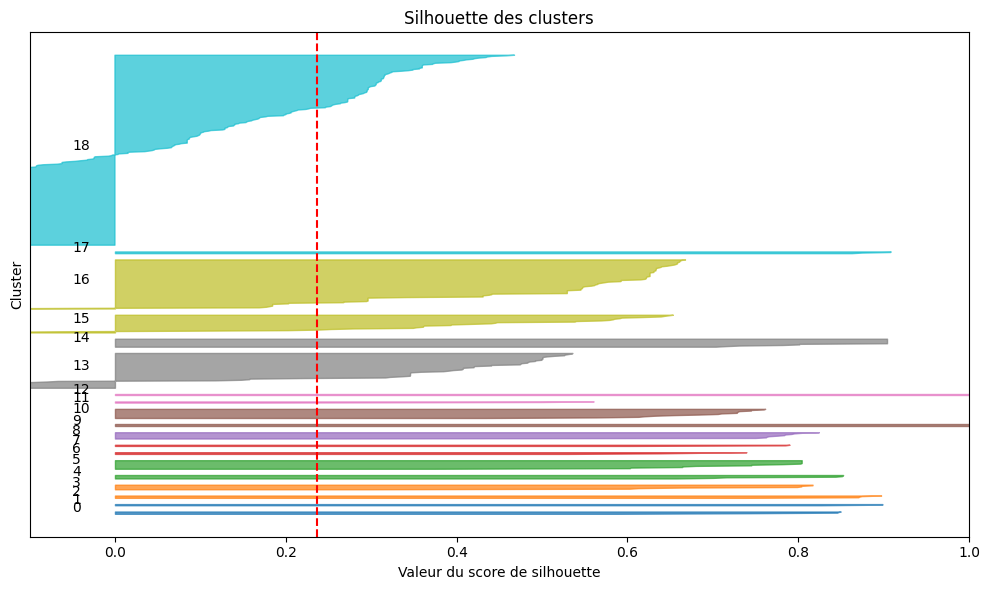

'Score moyen silhouette : 0.23633828467911022'

In [56]:
# Calculer le score de silhouette pour tous les points
cluster_labels = data_map['cluster']
data_map_filtered = data_map[cluster_labels != -1] # Exclure le bruit (-1)
cluster_labels_filtered = cluster_labels[cluster_labels != -1]  # Exclure le bruit (-1)
n_clusters = len(set(cluster_labels_filtered))

silhouette_vals = silhouette_samples(data_map_filtered[['latitude', 'longitude']], cluster_labels_filtered)
silhouette_avg = silhouette_score(data_map_filtered[['latitude', 'longitude']], cluster_labels_filtered)

# Initialiser le tracé
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10  # Position de départ pour les silhouettes
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

# Tracer chaque cluster
for i, cluster_id in enumerate(sorted(set(cluster_labels_filtered))):

    # Scores de silhouette pour le cluster en cours
    cluster_silhouette_vals = silhouette_vals[cluster_labels_filtered == cluster_id]
    cluster_silhouette_vals.sort()

    cluster_size = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + cluster_size

    # Tracer les barres des silhouettes
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_vals,
        facecolor=colors[i],
        edgecolor=colors[i],
        alpha=0.7
    )

    # Ajouter une étiquette pour le cluster
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(cluster_id))

    y_lower = y_upper + 10  # Mise à jour de la position de départ pour le prochain cluster

# Ajouter des annotations et des lignes de référence
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title("Silhouette des clusters")
ax.set_xlabel("Valeur du score de silhouette")
ax.set_ylabel("Cluster")
ax.set_yticks([])  # Cacher les ticks de l'axe Y
ax.set_xlim([-0.1, 1])
plt.tight_layout()
plt.show()

display(f'Score moyen silhouette : {silhouette_avg}')

### Analyse des capacités de stockage

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

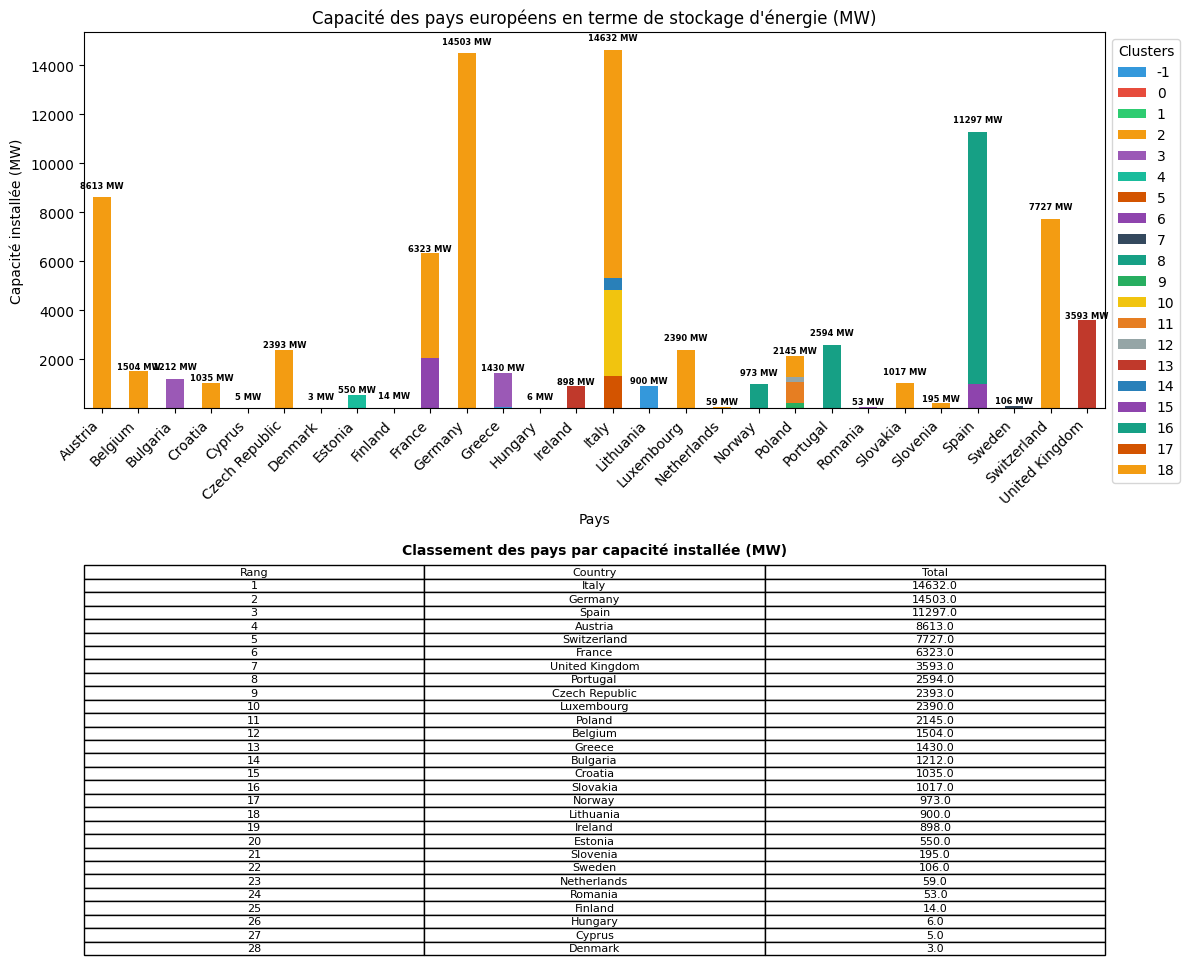

In [57]:
import matplotlib.gridspec as gridspec

# Création du tableau pivot
country_cluster_capacity = pd.pivot_table(
    data_map, values='Power installed capacity (MW)', index='Country',
    columns='cluster', aggfunc='sum', fill_value=0
)

# Ajout de la colonne total et tri
country_cluster_capacity['Total'] = country_cluster_capacity.sum(axis=1).round(0)

#Exporter le DataFrame
country_cluster_capacity.to_excel("classement_pays_stockage.xlsx", index=True, engine='openpyxl')
files.download("classement_pays_stockage.xlsx")

# Définition des couleurs des clusters
colors = [
    '#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#d35400',
    '#8e44ad', '#34495e', '#16a085', '#27ae60', '#f1c40f', '#e67e22', '#95a5a6',
    '#c0392b', '#2980b9', '#8e44ad', '#16a085', '#d35400', '#f39c12', '#7f8c8d',
    '#2c3e50', '#e74c3c', '#9b59b6', '#34495e', '#16a085', '#f1c40f', '#e67e22',
    '#ecf0f1', '#bdc3c7', '#7f8c8d'
]

# Création de la figure et du layout
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])  # 3 parts graph, 1 part table

# Ajout du graphique dans la première partie
ax1 = plt.subplot(gs[0])
country_cluster_capacity.drop(columns=['Total']).plot(
    kind='bar', stacked=True, ax=ax1, color=colors
)

# Ajout des valeurs sur les barres
for i, country in enumerate(country_cluster_capacity.index):
    total_capacity = country_cluster_capacity.loc[country, 'Total']
    if total_capacity > 0:
        offset = 300 if i % 2 == 0 else 20
        ax1.text(i, total_capacity + offset,
                 f'{total_capacity:.0f} MW', ha='center', va='bottom',
                 fontsize=6,fontweight="bold", color='black') #fontweight='bold'

ax1.legend(title="Clusters", loc='upper left', bbox_to_anchor=(1, 1))
ax1.set_title("Capacité des pays européens en terme de stockage d'énergie (MW)")
ax1.set_xlabel('Pays')
ax1.set_ylabel('Capacité installée (MW)')
ax1.set_xticklabels(country_cluster_capacity.index, rotation=45, ha='right')

# Création du tableau dans la seconde partie
ax2 = plt.subplot(gs[1])
ax2.axis('off')

# Ajouter un titre au tableau
fig.text(0.5, 0.44, "Classement des pays par capacité installée (MW)",
         fontsize=10,fontweight = "bold", ha="center")

# Création du classement sous forme de dataframe
country_ranking = country_cluster_capacity[['Total']].reset_index()
country_ranking['Rang'] = country_ranking['Total'].rank(ascending=False, method='min').astype(int)
country_ranking = country_ranking.sort_values(by='Rang')

# Réorganiser les colonnes dans l'ordre souhaité
country_ranking = country_ranking[['Rang', 'Country', 'Total']]

# Ajout du tableau sous forme de matplotlib.table
table_data = [['Rang', 'Country', 'Total']] + country_ranking.values.tolist()
table = ax2.table(cellText=table_data, colLabels=None, loc='center', cellLoc='center')

# Ajustement de la taille du tableau
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1)

# Sauvegarde en local
plt.tight_layout()
plt.savefig("classement_stockage_energie.png", dpi=300, bbox_inches="tight")
files.download("classement_stockage_energie.png")

# Affichage final
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

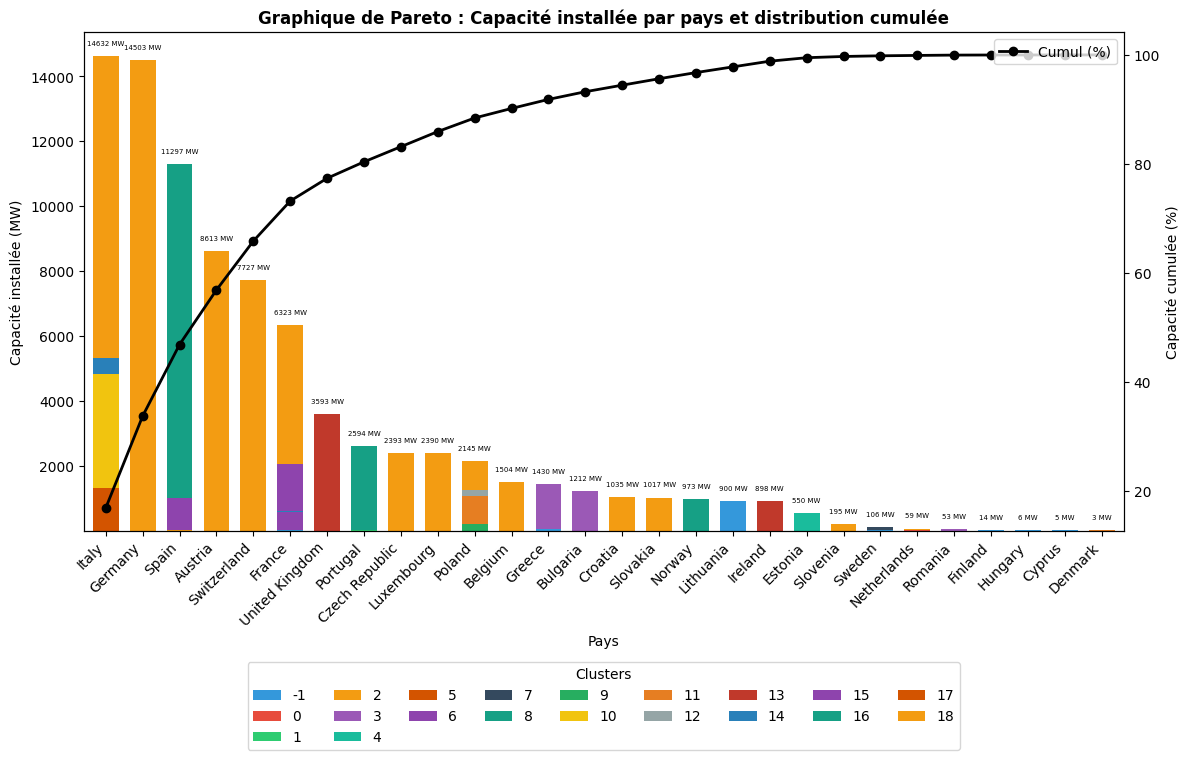

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# Création du tableau pivot
country_cluster_capacity = pd.pivot_table(
    data_map, values='Power installed capacity (MW)', index='Country',
    columns='cluster', aggfunc='sum', fill_value=0
)

# Ajout de la colonne total et tri
country_cluster_capacity['Total'] = country_cluster_capacity.sum(axis=1).round(0)
country_cluster_capacity = country_cluster_capacity.sort_values(by='Total', ascending=False)

# Calcul de la capacité cumulée et du pourcentage cumulé
country_cluster_capacity['Cumulative'] = country_cluster_capacity['Total'].cumsum()
country_cluster_capacity['Cumulative %'] = (country_cluster_capacity['Cumulative'] / country_cluster_capacity['Total'].sum()) * 100

# Définition des couleurs des clusters
colors = [
    '#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#d35400',
    '#8e44ad', '#34495e', '#16a085', '#27ae60', '#f1c40f', '#e67e22', '#95a5a6',
    '#c0392b', '#2980b9', '#8e44ad', '#16a085', '#d35400', '#f39c12', '#7f8c8d',
    '#2c3e50', '#e74c3c', '#9b59b6', '#34495e', '#16a085', '#f1c40f', '#e67e22',
    '#ecf0f1', '#bdc3c7', '#7f8c8d'
]

# Création de la figure et du layout
fig, ax1 = plt.subplots(figsize=(12, 8))

# Graphique en barres empilées (capacité par cluster)
country_cluster_capacity.drop(columns=['Total', 'Cumulative', 'Cumulative %']).plot(
    kind='bar', stacked=True, ax=ax1, color=colors, width=0.7
)

# Création d'un axe secondaire pour la courbe cumulative
ax2 = ax1.twinx()
ax2.plot(country_cluster_capacity.index, country_cluster_capacity['Cumulative %'],
         marker='o', color='black', linestyle='-', linewidth=2, label="Cumul (%)")

# Ajout des valeurs sur les barres
for i, country in enumerate(country_cluster_capacity.index):
    total_capacity = country_cluster_capacity.loc[country, 'Total']
    ax1.text(i, total_capacity + 300, f'{total_capacity:.0f} MW', ha='center', va='bottom',
             fontsize=5, color='black')

# Configuration des axes
ax1.set_xlabel('Pays')
ax1.set_ylabel('Capacité installée (MW)', color='black')
ax2.set_ylabel('Capacité cumulée (%)', color='black')
ax1.set_xticklabels(country_cluster_capacity.index, rotation=45, ha='right')

# Légendes
ax1.legend(title="Clusters", loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=9)
ax2.legend(loc='upper right')

# Ajout du titre
plt.title("Graphique de Pareto : Capacité installée par pays et distribution cumulée", fontsize=12, fontweight='bold')

# Sauvegarde en local
plt.tight_layout()
plt.savefig("pareto_stockage_energie.png", dpi=300, bbox_inches="tight")
files.download("pareto_stockage_energie.png")

# Affichage final
plt.show()


## Graph des technologies par pays et clusters

In [59]:
# Create the table with inverted index and columns, ignoring NaN values
country_cluster_tech = pd.pivot_table(data_map,
                                      values='Facility Name',  # Define the column you want to use
                                      index=['Country', 'cluster'],  # Rows (index) of the pivot table
                                      columns=['Technology type', 'Sub-technology'],  # Columns of the pivot table
                                      aggfunc= 'count',  # Exclude NaN values
                                      fill_value=0)  # Fill missing values with NaN

# Display the result
country_cluster_tech

Technology type                 Chemical  \
Sub-technology         Power to Gas (H2)   
Country        cluster                     
Austria         18                     0   
Belgium         18                     0   
Bulgaria        3                      0   
Croatia         18                     0   
Czech Republic  18                     0   
Denmark        -1                      0   
                18                     0   
Estonia         4                      0   
Finland        -1                      0   
                4                      0   
France         -1                      0   
                0                      0   
                6                      0   
                14                     0   
                15                     0   
                17                     0   
                18                     0   
Germany         18                     1   
Greece         -1                      0   
                3                      0   
Hungary        -1                      0   
                18                     0   
Ireland         13                     0   
Italy           5                      0   
                10                     0   
                14                     0   
                18                     0   
Lithuania      -1                      0   
Luxembourg      18                     0   
Netherlands     0                      0   
                18                     0   
Norway         -1                      0   
                8                      0   
Poland          9                      0   
                11                     0   
                12                     0   
                18                     0   
Portugal        1                      0   
                16                     0   
Romania         3                      0   
Slovakia        18                     0   
Slovenia        18                     0   
Spain           2                      0   
                15                     0   
                16                     0   
Sweden         -1                      0   
                7                      0   
Switzerland     18                     0   
United Kingdom -1                      0   
                13                     0   

Technology type        Electro-chemical battery and chemical storage  \
Sub-technology                                   Lead Acid batteries   
Country        cluster                                                 
Austria         18                                                 0   
Belgium         18                                                 1   
Bulgaria        3                                                  0   
Croatia         18                                                 0   
Czech Republic  18                                                 0   
Denmark        -1                                                  0   
                18                                                 0   
Estonia         4                                                  0   
Finland        -1                                                  0   
                4                                                  0   
France         -1                                                  0   
                0                                                  0   
                6                                                  0   
                14                                                 0   
                15                                                 1   
                17                                                 0   
                18                                                 0   
Germany         18                                                 6   
Greece         -1                                                  0   
                3                                                  0   
Hungary    

In [60]:
import plotly.express as px

# Préparer les données pour le Sunburst plot
sunburst_data = []

# Iterate over the pivot table
for (country, cluster), row in country_cluster_tech.iterrows():
    for (tech_type, sub_tech), count in row.items():
        # Append the data to the sunburst_data list
        sunburst_data.append({
            "Country": country,
            "Cluster": f'Cluster : {cluster}',
            "Technology Type": tech_type,
            "Sub-Technology": sub_tech,
            "Count": count
        })

# Convertir les données en DataFrame
sunburst_df = pd.DataFrame(sunburst_data)

# Créer le graphique Sunburst
fig = px.sunburst(
    sunburst_df,
    path=["Country", "Cluster", "Sub-Technology"],
    values="Count",
    title="Technology Distribution by Country, Cluster, and Sub-Technology",
    hover_data={"Count": True}  # Affichage du nombre de counts au survol
)

# Modifier les traces pour améliorer la lisibilité
fig.update_traces(
    textinfo="label+value",  # Affiche le nom + valeur (Count) sur les tranches
    hovertemplate="<b>%{label}</b><br> Count : <i>%{value}</i><extra></extra>"  # Italique sur Count
)

# Ajuster la mise en page pour une meilleure lisibilité
fig.update_layout(
    width=1200,
    height=800,
    font=dict(size=12),
    title=dict(
        text="Distribution des emplacements de stockage d'énergie par pays et par Cluster",
        font=dict(size=18),
        x=0.5,
        xanchor='center'
    ),
    margin=dict(t=50, b=50, l=50, r=50)
)

# Exporter en HTML
export_path = "sunburst_répartition_technologies_pays_all.html"
fig.write_html(export_path)
print(f"Plot saved as interactive HTML to {export_path}")
files.download(export_path)

# Afficher le graphique
fig.show()


Plot saved as interactive HTML to sunburst_répartition_technologies_pays_all.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
import plotly.express as px
import pandas as pd

# Demander à l'utilisateur le nombre de pays à afficher
n_pays = 8

# Trier les pays par capacité totale (ou autre critère, ici "Total") et prendre les n premiers
top_countries = country_cluster_capacity['Total'].sort_values(ascending=False).head(n_pays).index

# Préparer les données pour le Sunburst plot
sunburst_data = []

# Itérer sur la table pivot, mais seulement pour les pays sélectionnés
for (country, cluster), row in country_cluster_tech.iterrows():
    if country in top_countries:  # Filtrer par les pays sélectionnés
        for (tech_type, sub_tech), count in row.items():
            # Ajouter les données au tableau sunburst_data
            sunburst_data.append({
                "Country": country,
                "Cluster": f'Cluster : {cluster}',
                "Technology Type": tech_type,
                "Sub-Technology": sub_tech,
                "Count": count
            })

# Convertir les données en DataFrame
sunburst_df = pd.DataFrame(sunburst_data)

# Créer le graphique Sunburst
fig = px.sunburst(
    sunburst_df,
    path=["Country", "Cluster", "Sub-Technology"],
    values="Count",
    title="Technology Distribution by Country, Cluster, and Sub-Technology",
    hover_data={"Count": True}  # Affichage du nombre de counts au survol
)

# Modifier les traces pour améliorer la lisibilité
fig.update_traces(
    textinfo="label+value",  # Affiche le nom + valeur (Count) sur les tranches
    hovertemplate="<b>%{label}</b><br> Count : <i>%{value}</i><extra></extra>"  # Italique sur Count
)

# Ajuster la mise en page pour une meilleure lisibilité
fig.update_layout(
    width=1200,
    height=800,
    font=dict(size=12),
    title=dict(
        text="Distribution des emplacements de stockage d'énergie par pays et par Cluster",
        font=dict(size=18),
        x=0.5,
        xanchor='center'
    ),
    margin=dict(t=50, b=50, l=50, r=50)
)

# Exporter en HTML
export_path = "sunburst_répartition_technologies_pays_top.html"
fig.write_html(export_path)
print(f"Plot saved as interactive HTML to {export_path}")
files.download(export_path)

# Afficher le graphique
fig.show()


Plot saved as interactive HTML to sunburst_répartition_technologies_pays_top.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Graph de la répartition des technologies

In [62]:
import plotly.express as px

# Préparer les données pour le Sunburst plot
sunburst_data = []

# Parcourir le tableau croisé dynamique
for (country, cluster), row in country_cluster_tech.iterrows():
    for (tech_type, sub_tech), count in row.items():
        sunburst_data.append({
            "Country": country,
            "Cluster": f'Cluster : {cluster}',
            "Technology Type": tech_type,
            "Sub-Technology": sub_tech,
            "Count": count
        })

# Convertir les données en DataFrame
sunburst_df = pd.DataFrame(sunburst_data)

# Créer le graphique Sunburst
fig = px.sunburst(
    sunburst_df,
    path=["Sub-Technology", "Country"],
    values="Count",
    title="Lithium-ion batteries",
    hover_data={"Count": True}  # Affichage du nombre de counts au survol
)

# Modifier les traces pour améliorer la lisibilité
fig.update_traces(
    textinfo="label+value",  # Affiche le nom + valeur (Count) sur les tranches
    hovertemplate="<b>%{label}</b><br> Count : <i>%{value}</i><extra></extra>"  # Italique sur Count
)

# Ajuster la mise en page pour une meilleure lisibilité
fig.update_layout(
    width=1200,
    height=800,
    font=dict(size=12),
    title=dict(
        text="Distribution des technologies de stockage en Europe",
        font=dict(size=18),
        x=0.5,
        xanchor='center'
    ),
    margin=dict(t=50, b=50, l=50, r=50)
)

# Exporter en HTML
export_path = "sunburst_repartition_technologies_all.html"
fig.write_html(export_path)
print(f"Plot saved as interactive HTML to {export_path}")
files.download(export_path)

# Afficher le graphique
fig.show()


Plot saved as interactive HTML to sunburst_repartition_technologies_all.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
data_map["Technology type"].unique()

array(['Mechanical', 'Electro-chemical battery and chemical storage',
       'ElectroChemical', 'Thermal', 'Chemical'], dtype=object)

In [64]:
data_map['Sub-technology'].unique()

array(['Pumped Hydro Storage (PHS)', 'Redox flow batteries Vanadium',
       'Lead Acid batteries', 'Sodium Sulphur batteries', nan, 'Flywheel',
       'Power to Gas (H2)', 'Lithium-ion batteries',
       'Sensible Thermal Energy Storage (STES)', 'Unknown',
       'Lithium-Metal-Polymer batteries',
       'Compressed Air Energy Storage (CAES)', 'Supercapacitor',
       'Phase Change Material (PCM)', 'Molten salts',
       'Nickel-based batteries',
       'Lead Acid batteries + Lithium-ion batteries'], dtype=object)